<a href="https://colab.research.google.com/github/crazy85128x/ML0930/blob/master/transfer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import zipfile
f = zipfile.ZipFile("drive/My Drive/train.zip")
f.extractall()

In [2]:
import pandas as pd
import glob
dogs = glob.glob("train/dog.*")
cats = glob.glob("train/cat.*")
df = pd.DataFrame({
    "path":dogs + cats,
    "target":[0] * len(dogs) + [1] * len(cats)
})
df

,path,target
0,train/dog.9287.jpg,0
1,train/dog.2877.jpg,0
2,train/dog.8792.jpg,0
3,train/dog.4978.jpg,0
4,train/dog.981.jpg,0
...,...,...
24995,train/cat.10328.jpg,1
24996,train/cat.517.jpg,1
24997,train/cat.257.jpg,1
24998,train/cat.10261.jpg,1


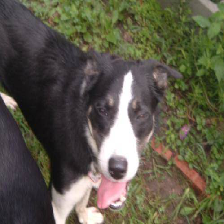

In [4]:
import random
from tensorflow.keras.preprocessing.image import load_img
idx = random.randint(0, 24999)
load_img(df["path"][idx], target_size=(224, 224))

In [5]:
import numpy as np
from sklearn.model_selection import train_test_split
x, y = np.array(df["path"]), np.array(df["target"])
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.1)
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(22500,)
(2500,)
(22500,)
(2500,)
